In [1]:
import torch
import torch.optim as optim
import torchvision
from torchvision import transforms, datasets, models
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data_utils
from torch.autograd import Variable

import pandas as pd
import numpy as np
import os

from tqdm import tqdm

from skimage import io as skio

from IPython.display import clear_output
import matplotlib.pyplot as plt

In [2]:
cuda_device=5

In [3]:
train = pd.read_csv('train_ready.csv')
val = pd.read_csv('valid_ready.csv')
test = pd.read_csv('test_ready.csv')

In [4]:
class Unet_down(nn.Module):
    def __init__(self, inp, oup):
        super(self.__class__, self).__init__()
        self.conv0 = nn.Conv2d(in_channels=inp, out_channels=oup, kernel_size=3, padding=1)
        self.norm = nn.BatchNorm2d(num_features=oup)
        self.drop = nn.Dropout2d()
        
    
    def forward(self, X):
        return F.max_pool2d(self.drop(self.norm(F.leaky_relu(self.conv0(X)))), 2)

In [5]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [6]:
class Unet(nn.Module):
    def __init__(self):
        super(self.__class__, self).__init__()
        
        self.l1 = Unet_down(1, 64)
        self.l2 = Unet_down(64, 128)
        self.l3 = Unet_down(128, 128)
        self.l4 = Unet_down(128, 128)
        self.l5 = Unet_down(128, 128)
        self.l6 = Unet_down(128, 256)
        self.l7 = Unet_down(256, 256)
        self.l8 = Flatten()
        self.l9 = nn.Linear(1024, 2)
        
        
    def forward(self, X):
        X1 = self.l1.forward(X)
        X2 = self.l2.forward(X1)
        X3 = self.l3.forward(X2)
        X4 = self.l4.forward(X3)
        X5 = self.l5.forward(X4)
        X6 = self.l6.forward(X5)
        X7 = self.l7.forward(X6)
        X8 = self.l8.forward(X7)
        return self.l9.forward(X8)

In [7]:
net = Unet().cuda(cuda_device)
opt = optim.Adam(net.parameters())

In [8]:
X_train = []
X_val = []
X_test = []
y_train = []
y_val = []
y_test = []

In [9]:
files = set(os.listdir('data'))

In [10]:
for i in tqdm(range(train.shape[0])):
    if train.loc[i, 'filename'].split('\\')[-1] in files:
        X_train.append(skio.imread('data/' + train.loc[i, 'filename'].split('\\')[-1]))
        y_train.append(train.loc[i, 'label'])
        
for i in tqdm(range(val.shape[0])):
    if val.loc[i, 'filename'].split('\\')[-1] in files:
        X_val.append(skio.imread('data/' + val.loc[i, 'filename'].split('\\')[-1]))
        y_val.append(train.loc[i, 'label'])
        
for i in tqdm(range(test.shape[0])):
    if test.loc[i, 'filename'].split('\\')[-1] in files:
        X_test.append(skio.imread('data/' + test.loc[i, 'filename'].split('\\')[-1]))
        y_test.append(test.loc[i, 'label'])

100%|██████████| 17241/17241 [00:00<00:00, 29561.61it/s]


In [11]:
X_train = np.array(X_train).reshape(-1, 1, 256, 256) / 255
X_val = np.array(X_val).reshape(-1, 1, 256, 256) / 255
X_test = np.array(X_test).reshape(-1, 1, 256, 256) / 255
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

In [15]:
train_d = data_utils.TensorDataset(torch.Tensor(X_train), torch.LongTensor(y_train))
train_loader = data_utils.DataLoader(train_d, batch_size=10, shuffle=True)

val_d = data_utils.TensorDataset(torch.Tensor(X_val), torch.LongTensor(y_val))
val_loader = data_utils.DataLoader(val_d, batch_size=10, shuffle=True)

test_d = data_utils.TensorDataset(torch.Tensor(X_test), torch.LongTensor(y_test))
test_loader = data_utils.DataLoader(test_d, batch_size=10, shuffle=True)

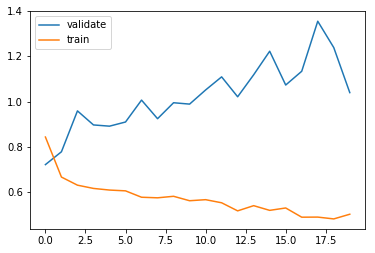

100%|██████████| 20/20 [01:39<00:00,  4.95s/it]


In [13]:
n_epoch = 20
val_scores = []
train_scores = []
for epoch in tqdm(range(n_epoch)):
    
    val_loss = 0
    train_loss = 0
    i = 0
    net.train()
    
    for (x_batch, y_batch) in train_loader:
        x_batch = Variable(x_batch).cuda(cuda_device)
        y_batch = Variable(y_batch).cuda(cuda_device)
        loss = F.cross_entropy(net.forward(x_batch), y_batch).cuda(cuda_device)
        opt.zero_grad()
        loss.backward()
        opt.step()
        train_loss += loss.cpu().data.numpy()
        i += 1
    
    train_scores.append(train_loss / i)
    i = 0
    net.eval()
    
    for (x_batch, y_batch) in val_loader:
        x_batch = Variable(x_batch).cuda(cuda_device)
        y_batch = Variable(y_batch).cuda(cuda_device)
        loss = F.cross_entropy(net.forward(x_batch), y_batch).cuda(cuda_device)
        val_loss += loss.cpu().data.numpy()
        i += 1
    
    val_scores.append(val_loss / i)
    
    clear_output()
    plt.plot(val_scores, label='validate')
    plt.plot(train_scores, label='train')
    plt.legend()
    plt.xlabel='epoch'
    plt.ylabel='entropy score'
    plt.show()

In [35]:
loss = 0
for (x_batch, y_batch) in test_loader:
        x_batch = Variable(x_batch).cuda(cuda_device)
        y_batch = Variable(y_batch).cuda(cuda_device)
        pred = net.forward(x_batch).max(dim=1)[1]
        loss += (y_batch == pred).sum().cpu().data.numpy()

In [36]:
print(loss / X_test.shape[0])

[0.75384615]
